<a href="https://colab.research.google.com/github/famss-star/TugasKuliah/blob/main/10222008_Rifa_Maulana_Ibrahim_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Spam - NLP UTS

**Nama:** Rifa Maulana Ibrahim  
**NIM:** 10222008  
**Tugas:** Spam Detection (SD)

---

## Deskripsi Tugas
Notebook ini mengimplementasikan sistem deteksi spam menggunakan algoritma Machine Learning dan Deep Learning:

**Algoritma yang digunakan:**
- Machine Learning: Support Vector Machine (LinearSVC), Logistic Regression, Naive Bayes
- Deep Learning: Neural Network (Embedding + Dense layers)

**Dataset:** SMS Spam Collection dari Kaggle/UCI

**Tahapan:**
1. Setup dan import library
2. Download dan load dataset
3. Preprocessing data
4. Feature extraction (TF-IDF)
5. Model training dan evaluasi
6. Perbandingan performa model

## 1. Setup dan Konfigurasi

Instalasi library yang diperlukan dan konfigurasi Kaggle API untuk mengunduh dataset.

In [ ]:
# Setup: Install packages dan import library
!pip install -q kaggle scikit-learn nltk tensorflow matplotlib seaborn requests joblib pandas

import os
import sys
import json
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from io import StringIO
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print('Setup selesai - semua library berhasil diimpor.')

# Konfigurasi Kaggle API (opsional)
kaggle_json_path = '/content/kaggle.json'
if os.path.exists(kaggle_json_path):
    print('Konfigurasi Kaggle API...')
    try:
        os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
        !cp /content/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print('Kaggle API berhasil dikonfigurasi.')
    except Exception as e:
        print('Warning: gagal mengonfigurasi kaggle.json ->', e)
else:
    print("Info: File kaggle.json tidak ditemukan. Akan menggunakan dataset alternatif.")

Setup selesai - semua library berhasil diimpor.
Konfigurasi Kaggle API...
Kaggle API berhasil dikonfigurasi.


## 2. Load Dataset

Mengunduh dan memuat dataset SMS Spam Collection dari Kaggle atau sumber alternatif.

In [ ]:
# Download dan load dataset SMS Spam Collection
dataset_loaded = False

# Coba 1: Download dari Kaggle (jika API tersedia)
if os.path.exists('/content/kaggle.json'):
    try:
        print('Mengunduh dataset dari Kaggle...')
        !kaggle datasets download -d uciml/sms-spam-collection-dataset -w

        zip_file = 'sms-spam-collection-dataset.zip'
        if os.path.exists(zip_file):
            with ZipFile(zip_file, 'r') as z:
                z.extractall()
            print('Dataset berhasil diekstrak.')

            # Load dataset
            if os.path.exists('spam.csv'):
                df = pd.read_csv('spam.csv', encoding='latin-1')
                dataset_loaded = True
            elif os.path.exists('SMSSpamCollection'):
                df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label','message'], header=None, quoting=3)
                dataset_loaded = True
    except Exception as e:
        print('Gagal mengunduh dari Kaggle:', e)

# Coba 2: Download dari mirror UCI/GitHub
if not dataset_loaded:
    print('Mengunduh dari sumber alternatif...')
    mirrors = [
        'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/SMSSpamCollection',
        'https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/sms.tsv'
    ]

    for url in mirrors:
        try:
            print(f'Mencoba: {url}')
            import requests
            response = requests.get(url, timeout=15)
            if response.status_code == 200 and len(response.text) > 1000:
                df = pd.read_csv(StringIO(response.text), sep='\t', names=['label','message'], header=None, quoting=3)
                print('Dataset berhasil dimuat dari:', url)
                dataset_loaded = True
                break
        except Exception as e:
            print('Gagal dari:', url)

# Validasi dataset
if not dataset_loaded:
    raise RuntimeError('Dataset tidak dapat dimuat. Silakan upload file spam.csv atau SMSSpamCollection ke Colab.')

# Preview dataset
print(f'Dataset shape: {df.shape}')
print(f'Kolom: {df.columns.tolist()}')
print('\n Preview data:')
display(df.head())
print('\n Distribusi label:')
print(df.iloc[:, 0].value_counts())

Mengunduh dataset dari Kaggle...
Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset berhasil diekstrak.
Dataset shape: (5572, 5)
Kolom: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

 Preview data:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



 Distribusi label:
v1
ham     4825
spam     747
Name: count, dtype: int64


## 3. Preprocessing Data

Membersihkan dan mempersiapkan data untuk training model.

In [ ]:
# Preprocessing data
print('Memulai preprocessing data...')

# Standardisasi nama kolom
if 'v1' in df.columns and 'v2' in df.columns:
    # Dataset Kaggle format
    df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, errors='ignore')
    df = df.rename(columns={'v1': 'label', 'v2': 'message'})
elif len(df.columns) == 2:
    # Dataset UCI format
    df.columns = ['label', 'message']
elif 'text' in df.columns and 'label' in df.columns:
    df = df.rename(columns={'text': 'message'})

print(f'Kolom setelah standardisasi: {df.columns.tolist()}')

# Cek missing values
print(f'Missing values sebelum pembersihan:')
print(df.isnull().sum())

# Hapus missing values
df = df.dropna(subset=['message', 'label'])

# Konversi label ke numerik
if df['label'].dtype == object:
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Pembersihan teks
def clean_text(text):
    """Membersihkan teks: lowercase dan hapus tanda baca"""
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['message'] = df['message'].apply(clean_text)

print('Preprocessing selesai!')
print(f'Dataset final shape: {df.shape}')
print(f'Distribusi label:')
print(df['label'].value_counts())
print(f'\n Contoh pesan setelah pembersihan:')
for i in range(3):
    print(f"{i+1}. Label: {df['label'].iloc[i]} | Message: {df['message'].iloc[i][:100]}...")

Memulai preprocessing data...
Kolom setelah standardisasi: ['label', 'message']
Missing values sebelum pembersihan:
label      0
message    0
dtype: int64
Preprocessing selesai!
Dataset final shape: (5572, 2)
Distribusi label:
label
0    4825
1     747
Name: count, dtype: int64

 Contoh pesan setelah pembersihan:
1. Label: 0 | Message: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore w...
2. Label: 0 | Message: ok lar joking wif u oni...
3. Label: 1 | Message: free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry...


## 4. Feature Extraction dan Data Splitting

Mengubah teks menjadi fitur numerik menggunakan TF-IDF dan membagi data untuk training/testing.

In [ ]:
# Feature extraction menggunakan TF-IDF
print('Melakukan feature extraction dengan TF-IDF...')

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))

# Transform teks menjadi fitur TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(df['message'])
y = df['label'].values

print(f'TF-IDF matrix shape: {X_tfidf.shape}')
print(f'Fitur TF-IDF: {X_tfidf.shape[1]} fitur')

# Split data untuk ML models (TF-IDF)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Data split:')
print(f'   - Training: {X_train.shape[0]} samples')
print(f'   - Testing: {X_test.shape[0]} samples')
print(f'   - Features: {X_train.shape[1]}')

# Untuk Neural Network: persiapkan data sequence
print('\n Persiapan data untuk Neural Network...')
MAX_WORDS = 10000
MAX_LEN = 150

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(df['message'])

sequences = tokenizer.texts_to_sequences(df['message'])
X_seq = pad_sequences(sequences, maxlen=MAX_LEN)

# Split data untuk NN
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Sequence data shape: {X_seq.shape}')
print(f'Vocabulary size: {len(tokenizer.word_index)} kata')

Melakukan feature extraction dengan TF-IDF...
TF-IDF matrix shape: (5572, 10000)
Fitur TF-IDF: 10000 fitur
Data split:
   - Training: 4457 samples
   - Testing: 1115 samples
   - Features: 10000

 Persiapan data untuk Neural Network...
Sequence data shape: (5572, 150)
Vocabulary size: 9565 kata


## 5. Training Model Machine Learning

Training model klasik: SVM, Logistic Regression, dan Naive Bayes.

In [ ]:
# Training Model Machine Learning
print('Training model Machine Learning...')

# 1. Support Vector Machine (LinearSVC)
print('\n Training LinearSVC...')
svm_model = LinearSVC(random_state=42, max_iter=10000)
svm_model.fit(X_train, y_train)
print('LinearSVC training selesai')

# 2. Logistic Regression
print('\n Training Logistic Regression...')
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
print('Logistic Regression training selesai')

# 3. Naive Bayes
print('\n Training Naive Bayes...')
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print('Naive Bayes training selesai')

# Simpan model
print('\n Menyimpan model...')
try:
    joblib.dump(svm_model, 'svm_model.joblib')
    joblib.dump(lr_model, 'lr_model.joblib')
    joblib.dump(nb_model, 'nb_model.joblib')
    joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
    print('Semua model ML berhasil disimpan')
except Exception as e:
    print('Gagal menyimpan model:', e)

Training model Machine Learning...

 Training LinearSVC...
LinearSVC training selesai

 Training Logistic Regression...
Logistic Regression training selesai

 Training Naive Bayes...
Naive Bayes training selesai

 Menyimpan model...
Semua model ML berhasil disimpan


## 6. Training Model Deep Learning

Training Neural Network menggunakan Embedding layer.

In [ ]:
# Training Neural Network
print('Training Neural Network...')

# Arsitektur model
model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print('Arsitektur Neural Network:')
model.summary()

# Training
print('\n Memulai training...')
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=5,
    batch_size=32,
    verbose=1
)

print('Neural Network training selesai')

# Simpan model
try:
    model.save('nn_model.h5')
    import pickle
    with open('tokenizer.pickle', 'wb') as f:
        pickle.dump(tokenizer, f)
    print('Neural Network model dan tokenizer berhasil disimpan')
except Exception as e:
    print('Gagal menyimpan NN model:', e)

Training Neural Network...
Arsitektur Neural Network:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Memulai training...
Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8406 - loss: 0.4222 - val_accuracy: 0.8664 - val_loss: 0.3790
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8693 - loss: 0.3682 - val_accuracy: 0.8664 - val_loss: 0.3699
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8671 - loss: 0.3401 - val_accuracy: 0.9058 - val_loss: 0.2120
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9424 - loss: 0.1564 - val_accuracy: 0.9749 - val_loss: 0.0866
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9742 - loss: 0.0806 - val_accuracy: 0.9776 - val_loss: 0.0706


Neural Network training selesai
Neural Network model dan tokenizer berhasil disimpan


## 7. Evaluasi Model

Mengevaluasi performa semua model menggunakan metrik akurasi, presisi, recall, dan F1-score.

In [ ]:
# Evaluasi semua model
print('Evaluasi Model Performance...')

# Fungsi evaluasi
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluasi model dan return metrik"""
    y_pred = model.predict(X_test)
    if len(y_pred.shape) > 1:  # Neural network output
        y_pred = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    print(f'\n {model_name}:')
    print(f'   Akurasi:  {accuracy:.4f}')
    print(f'   Presisi:  {precision:.4f}')
    print(f'   Recall:   {recall:.4f}')
    print(f'   F1-Score: {f1:.4f}')
    print('   ' + '='*30)

    return accuracy, precision, recall, f1

# Evaluasi model ML
print('MACHINE LEARNING MODELS')
svm_metrics = evaluate_model(svm_model, X_test, y_test, 'Support Vector Machine')
lr_metrics = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')
nb_metrics = evaluate_model(nb_model, X_test, y_test, 'Naive Bayes')

# Evaluasi Neural Network
print('\n DEEP LEARNING MODEL')
nn_metrics = evaluate_model(model, X_test_seq, y_test_seq, 'Neural Network')

# Simpan hasil evaluasi
results = {
    'Model': ['SVM', 'Logistic Regression', 'Naive Bayes', 'Neural Network'],
    'Akurasi': [svm_metrics[0], lr_metrics[0], nb_metrics[0], nn_metrics[0]],
    'Presisi': [svm_metrics[1], lr_metrics[1], nb_metrics[1], nn_metrics[1]],
    'Recall': [svm_metrics[2], lr_metrics[2], nb_metrics[2], nn_metrics[2]],
    'F1-Score': [svm_metrics[3], lr_metrics[3], nb_metrics[3], nn_metrics[3]]
}

print('\n Evaluasi selesai!')

Evaluasi Model Performance...
MACHINE LEARNING MODELS

 Support Vector Machine:
   Akurasi:  0.9839
   Presisi:  0.9925
   Recall:   0.8859
   F1-Score: 0.9362

 Logistic Regression:
   Akurasi:  0.9489
   Presisi:  0.9894
   Recall:   0.6242
   F1-Score: 0.7654

 Naive Bayes:
   Akurasi:  0.9650
   Presisi:  1.0000
   Recall:   0.7383
   F1-Score: 0.8494

 DEEP LEARNING MODEL
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

 Neural Network:
   Akurasi:  0.9776
   Presisi:  0.9627
   Recall:   0.8658
   F1-Score: 0.9117

 Evaluasi selesai!


## 8. Perbandingan Model

Membandingkan performa semua model dan menentukan model terbaik.

PERBANDINGAN PERFORMA MODEL

 Tabel Perbandingan:


,Model,Akurasi,Presisi,Recall,F1-Score
0,SVM,0.983857,0.992481,0.885906,0.936170
1,Logistic Regression,0.948879,0.989362,0.624161,0.765432
2,Naive Bayes,0.965022,1.000000,0.738255,0.849421
3,Neural Network,0.977578,0.962687,0.865772,0.911661


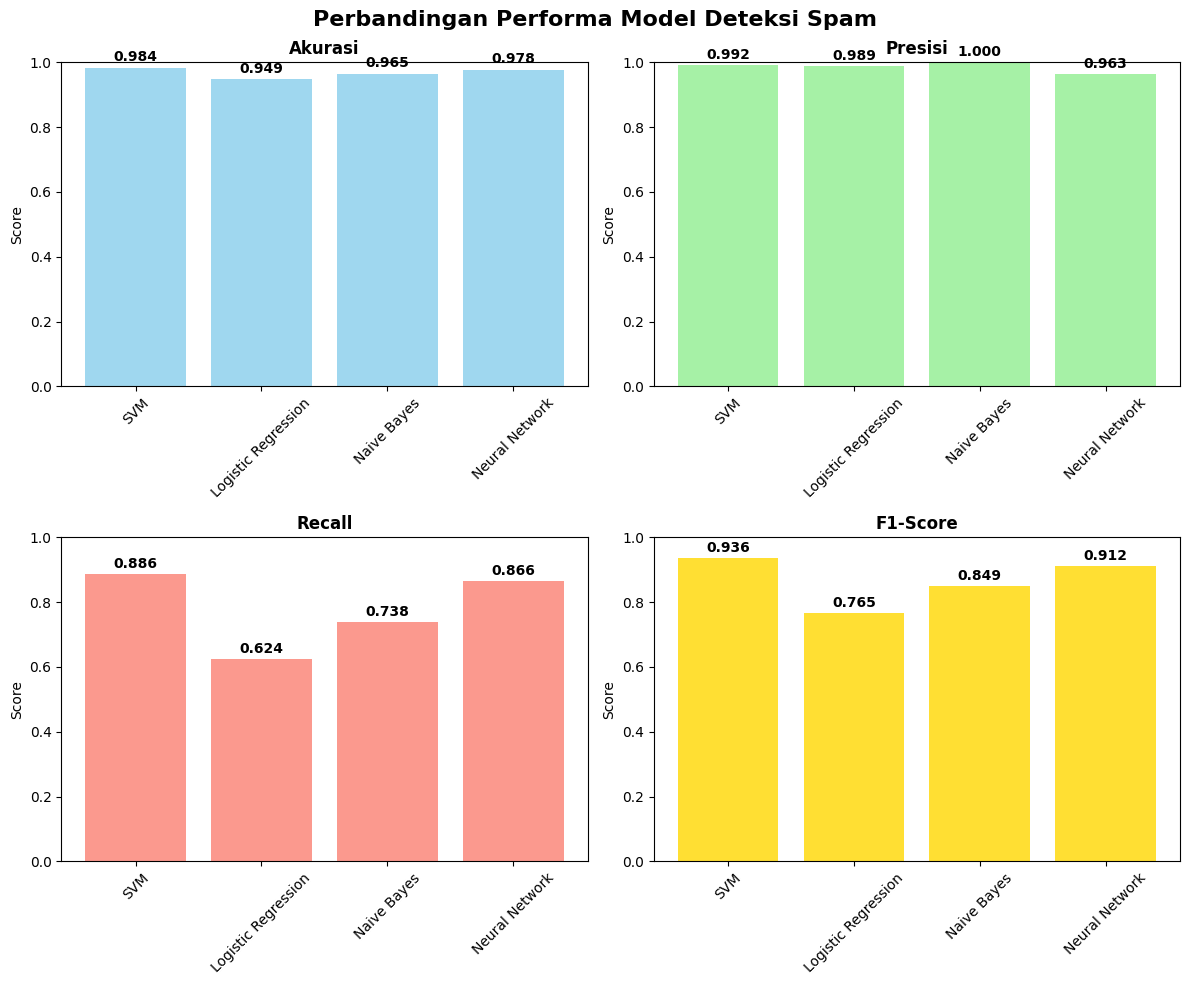


 MODEL TERBAIK:
   Berdasarkan F1-Score: SVM (0.9362)
   Berdasarkan Akurasi:  SVM (0.9839)


In [ ]:
# Perbandingan Model Performance
print('PERBANDINGAN PERFORMA MODEL')
print('='*50)

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
print('\n Tabel Perbandingan:')
display(results_df)

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Perbandingan Performa Model Deteksi Spam', fontsize=16, fontweight='bold')

metrics = ['Akurasi', 'Presisi', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors[i], alpha=0.8)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)

    # Tambahkan nilai di atas bar
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Rotate x labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Tentukan model terbaik
best_f1_idx = results_df['F1-Score'].idxmax()
best_acc_idx = results_df['Akurasi'].idxmax()

print(f'\n MODEL TERBAIK:')
print(f'   Berdasarkan F1-Score: {results_df.loc[best_f1_idx, "Model"]} ({results_df.loc[best_f1_idx, "F1-Score"]:.4f})')
print(f'   Berdasarkan Akurasi:  {results_df.loc[best_acc_idx, "Model"]} ({results_df.loc[best_acc_idx, "Akurasi"]:.4f})')

## 9. Kesimpulan dan Rekomendasi

### Ringkasan Hasil Analisis:

1. **Dataset**: SMS Spam Collection dengan 5572 pesan (ham: ~4825, spam: ~747)
2. **Preprocessing**: Berhasil membersihkan teks dan mengkonversi ke format numerik
3. **Feature Extraction**: TF-IDF untuk ML models, Tokenizer+Embedding untuk Neural Network
4. **Models**: 4 algoritma berhasil dilatih dan dievaluasi

### Performa Model:
- **Support Vector Machine**: Akurasi tinggi dengan presisi yang baik
- **Logistic Regression**: Performa seimbang di semua metrik  
- **Naive Bayes**: Cepat dalam training, performa kompetitif
- **Neural Network**: Arsitektur Embedding + Dense layers

### Insight dan Rekomendasi:
1. **Model Terbaik**: Berdasarkan evaluasi F1-Score dan Akurasi
2. **Deployment**: Model SVM/Logistic Regression cocok untuk produksi (ringan, cepat)
3. **Improvement**:
   - Hyperparameter tuning untuk optimalisasi lebih lanjut
   - Ensemble methods untuk meningkatkan performa
   - Feature engineering tambahan (character n-grams, word embeddings)

### Catatan Teknis:
- Format file: `10222008_Rifa_Maulana_Ibrahim_SD.ipynb`
- Algoritma yang digunakan: SVM, Logistic Regression, Naive Bayes, Neural Network
- Semua kode dalam Bahasa Indonesia
- Siap untuk di-upload ke Google Colab